In [1]:
!python --version

Python 3.8.10


In [2]:
!pip install seaborn

In [3]:
!pip install tensorflow==2.9.0
!pip install ampligraph

In [4]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

### Выгрузить датасет из внешнего ресурса и сохранить его в локальном файле (это можно сделать вручную, если прямой ссылки на датасет нет)

In [5]:
df = pd.read_csv("C:/Users/pozdo/Documents/itmo/Графы знаний/rdflib/game_stats.csv")
df

,game_name,series_name,team_winner,team_loser,goals_winner,goals_loser,player_name,played_for_side,is_mvp,car,...,avg_speed_percentage,total_distance,time_slow_speed,time_boost_speed,time_supersonic,time_on_ground,time_low_in_air,time_high_in_air,powerslide_duration,powerslide_count
0,/replay/71cf9501-80bc-4e14-97d6-2dddfb5f2ca9?g...,/group/bds-vs-elv-t11lrnk4f7,TEAM BDS,ELEVATE,4,1,ExoTiiK,Blue,True,Fennec,...,67.48,504123,158.43,137.97,51.08,199.09,128.51,19.88,6.20,46
1,/replay/71cf9501-80bc-4e14-97d6-2dddfb5f2ca9?g...,/group/bds-vs-elv-t11lrnk4f7,TEAM BDS,ELEVATE,4,1,dralii,Blue,False,Fennec,...,73.26,543295,119.02,144.88,80.88,172.47,145.54,26.77,7.63,76
2,/replay/71cf9501-80bc-4e14-97d6-2dddfb5f2ca9?g...,/group/bds-vs-elv-t11lrnk4f7,TEAM BDS,ELEVATE,4,1,M0nkey M00n,Blue,False,Octane,...,71.91,538583,127.02,141.40,79.32,197.69,126.43,23.63,5.93,43
3,/replay/71cf9501-80bc-4e14-97d6-2dddfb5f2ca9?g...,/group/bds-vs-elv-t11lrnk4f7,TEAM BDS,ELEVATE,4,1,Sphinx,Orange,False,Fennec,...,69.17,522608,148.70,136.39,65.75,178.32,148.95,23.58,8.05,78
4,/replay/71cf9501-80bc-4e14-97d6-2dddfb5f2ca9?g...,/group/bds-vs-elv-t11lrnk4f7,TEAM BDS,ELEVATE,4,1,LCT,Orange,False,Fennec,...,74.48,563648,123.09,131.12,96.57,185.23,145.45,20.10,8.00,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,/replay/c4f9a6e5-54c1-4d78-ba6d-d686ec56f104?g...,/group/vit-vs-og-qp7enkbq8z,TEAM VITALITY,OG ESPORTS,1,0,Comm,Blue,False,Octane,...,66.26,489187,159.62,112.37,55.63,208.70,92.19,26.73,5.27,51
542,/replay/c4f9a6e5-54c1-4d78-ba6d-d686ec56f104?g...,/group/vit-vs-og-qp7enkbq8z,TEAM VITALITY,OG ESPORTS,1,0,JKnaps,Blue,False,Fennec,...,69.61,513127,136.90,125.34,65.31,180.39,124.70,22.46,10.53,117
543,/replay/c4f9a6e5-54c1-4d78-ba6d-d686ec56f104?g...,/group/vit-vs-og-qp7enkbq8z,TEAM VITALITY,OG ESPORTS,1,0,Radosinho,Orange,True,Fennec,...,71.09,517989,121.13,144.95,58.44,204.54,99.62,20.37,6.93,55
544,/replay/c4f9a6e5-54c1-4d78-ba6d-d686ec56f104?g...,/group/vit-vs-og-qp7enkbq8z,TEAM VITALITY,OG ESPORTS,1,0,Alpha54,Orange,False,Fennec,...,69.00,507389,126.34,150.05,51.20,187.73,113.66,26.20,9.23,98


# Проверка на целостность данных

In [6]:
df.isna().sum()

game_name                     0
series_name                   0
team_winner                   0
team_loser                    0
goals_winner                  0
goals_loser                   0
player_name                   0
played_for_side               0
is_mvp                        0
car                           0
score                         0
goals                         0
assists                       0
saves                         0
shots                         0
BPM                           0
average_boost                 0
time_0_boost                  0
time_100_boost                0
boost_collected               0
boost_stolen                  0
big_pads_collected            0
small_pads_collected          0
big_pads_stolen               0
small_pads_stolen             0
boost_used_supersonic         0
boost_overfill                0
boost_overfill_from_stolen    0
defensive_third_percentage    0
neutral_third_percentage      0
offensive_third_percentage    0
behind_b

# Создание training set

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
df["train"] = df.index.isin(train_df.index)

In [8]:
df.train.value_counts()

train
True     436
False    110
Name: count, dtype: int64

# Создание графа знаний

In [166]:
triples = []
for i, row in df[df["train"]].iterrows():
    # average_boost = (f"player{i}", "has_average_boost", row["average_boost"])
    # time_0_boost = (f"player{i}", "has_time_0_boost", row["time_0_boost"])
    # time_100_boost = (f"player{i}", "has_time_100_boost", row["time_100_boost"])
    # bpm = (f"player{i}", "has_BPM", row["BPM"])
    # boost_collected = (f"player{i}", "has_boost_collected", row["boost_collected"])
    # boost_stolen = (f"player{i}", "has_boost_stolen", row["boost_stolen"])
    # boost_used_supersonic = (f"player{i}", "has_boost_used_supersonic", row["boost_used_supersonic"])
    # boost_overfill = (f"player{i}", "has_boost_overfill", row["boost_overfill"])
    is_mvp = (f"player{i}", "is_mvp", row["is_mvp"])
    avg_dist_ball = (f"player{i}", "has_avg_dist_ball", row["avg_distance_ball"])

    triples.extend((is_mvp, avg_dist_ball))

In [167]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
#triples_df[(triples_df.subject=="player1") | (triples_df.object=="player1")]


In [168]:
len(triples)

872

# Обучение эмбеддинга на графе знаний

In [169]:
from ampligraph.evaluation import train_test_split_no_unseen

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=200, allow_duplication=True)


In [170]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (672, 3)
Test set size:  (200, 3)


In [171]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-3})

model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [172]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=200,
          verbose=True
          )

Epoch 1/200
53/53 [==============================] - 1s 13ms/step - loss: 39.3671
Epoch 2/200
53/53 [==============================] - 0s 1ms/step - loss: 36.2843
Epoch 3/200
53/53 [==============================] - 0s 1ms/step - loss: 29.2349
Epoch 4/200
53/53 [==============================] - 0s 2ms/step - loss: 24.2138
Epoch 5/200
53/53 [==============================] - 0s 2ms/step - loss: 20.8617
Epoch 6/200
53/53 [==============================] - 0s 2ms/step - loss: 18.5695
Epoch 7/200
53/53 [==============================] - 0s 1ms/step - loss: 16.8751
Epoch 8/200
53/53 [==============================] - 0s 1ms/step - loss: 15.6047
Epoch 9/200
53/53 [==============================] - 0s 1ms/step - loss: 14.6319
Epoch 10/200
53/53 [==============================] - 0s 1ms/step - loss: 13.8221
Epoch 11/200
53/53 [==============================] - 0s 2ms/step - loss: 13.1606
Epoch 12/200
53/53 [==============================] - 0s 1ms/step - loss: 12.6068
Epoch 13/200
53/53 [====

In [173]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

21/21 [==============================] - 1s 35ms/step


In [174]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.19
MR: 269.88
Hits@10: 0.20
Hits@3: 0.19
Hits@1: 0.17


# Кластеризация

In [203]:
import numpy as np

# Prepare the player entities and MVP status
player_entities = set([f"player{i}" for i, _ in enumerate(df[df["train"]].itertuples(), 1)])

# Create a dictionary for the player name to "player1", "player2", etc.
player_name_mapping = {original_name: f"player{i}" for i, original_name in enumerate(df["player_name"], 1)}

# Initialize lists for player embeddings and MVP status
player_embeddings = []
player_mvp = []  # List to store MVP status (0 or 1)
player_names = []

# Create the triples and store MVP status for each player
for i, row in df[df["train"]].iterrows():
    player_name = f"player{i}"  # Renamed player name
    
    # Get the MVP status (1 or 0)
    is_mvp = row["is_mvp"]
    
    # Add MVP status to the list (0 for non-MVP, 1 for MVP)
    player_mvp.append(is_mvp)
    
    # Append the player name and its vector embedding
    player_vector = model.get_embeddings([player_name])[0]
    player_embeddings.append(player_vector)
    player_names.append(player_name)

# Convert the list of player embeddings to a numpy array
player_embeddings = np.array(player_embeddings)

# player_mvp now contains the MVP status (0 or 1) for each player


In [204]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
player_embeddings_2d = pca.fit_transform(player_embeddings)


In [205]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(player_embeddings_2d)


C:\Windows\System32\tf_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


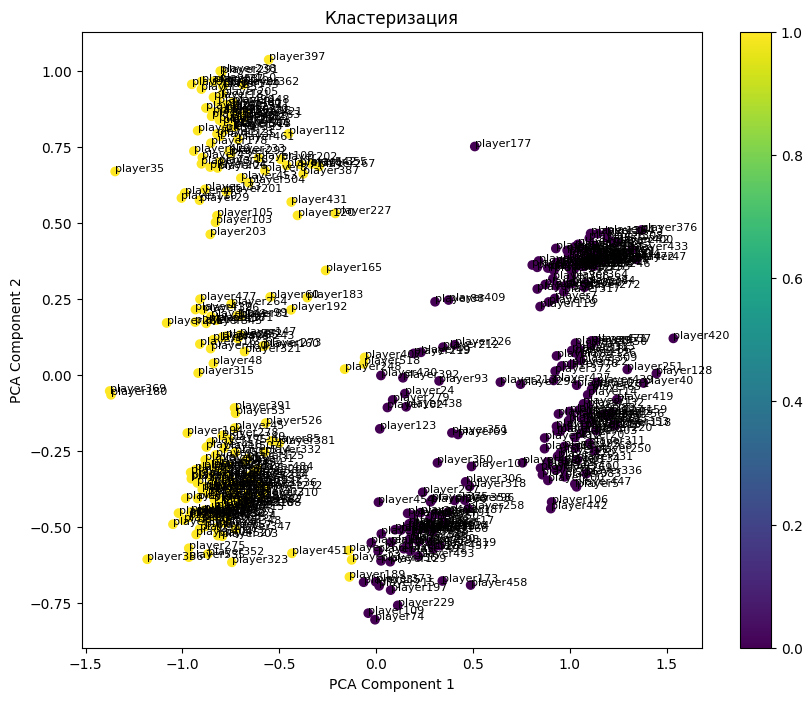

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(player_embeddings_2d[:, 0], player_embeddings_2d[:, 1], c=clusters, cmap='viridis')
plt.title('Кластеризация')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

for i, player_name in enumerate(player_names):
    plt.annotate(player_name, (player_embeddings_2d[i, 0], player_embeddings_2d[i, 1]), fontsize=8)

plt.colorbar()  
plt.show()


In [207]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(player_embeddings_2d, clusters)
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 0.6852710641422747


# Классификация

In [208]:
X = player_embeddings 
y = player_mvp

In [209]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(player_embeddings, player_mvp, test_size=0.2, random_state=42)


In [211]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 2.1/124.9 MB 19.5 MB/s eta 0:00:07
   ---- ----------------------------------- 12.8/124.9 MB 42.4 MB/s eta 0:00:03
   ------ --------------------------------- 20.7/124.9 MB 39.6 MB/s eta 0:00:03
   --------- ------------------------------ 29.4/124.9 MB 40.5 MB/s eta 0:00:03
   ------------ --------------------------- 39.1/124.9 MB 41.4 MB/s eta 0:00:03
   --------------- ------------------------ 49.0/124.9 MB 42.2 MB/s eta 0:00:02
   ------------------ --------------------- 59.0/124.9 MB 43.2 MB/s eta 0:00:02
   --------------------- ------------------ 68.4/124.9 MB 43.2 MB/s eta 0:00:02
   ------------------------- -------------- 79.2/124.9 MB 43.9 MB/s eta 0:00:02
   ---------------------------- ----------- 90.2/124.9 MB 45.0 MB/s eta 0:00:01
   ------------------------------- ------- 100.4/124.9 MB 45.1 MB/s eta 0:00:01
   ---------------------------------- ---- 111.4/1

In [218]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Создание и обучение модели XGBoost
model_xgb = xgb.XGBClassifier(eval_metric='logloss')
model_xgb.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model_xgb.predict(X_test)

# Оценка точности модели
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"точность XGBoost: {accuracy_xgb}")


точность XGBoost: 0.9204545454545454


In [216]:
# Преобразуем y_train в Pandas Series, чтобы использовать метод mode
y_train_series = pd.Series(y_train)

# Найдем самый частый класс
most_frequent_class = y_train_series.mode()[0]

# Прогнозирование самого частого класса
y_pred_baseline = [most_frequent_class] * len(y_test)

# Оценка точности базовой модели
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Точность базовой модели (самый частый класс): {accuracy_baseline}")

Точность базовой модели (самый частый класс): 0.8181818181818182


# Задача предсказания недостающих ссылок

In [230]:
train_triples = [triple for triple in triples if triple[0] in player_entities]  
test_triples = [triple for triple in triples if triple[0] in player_entities]  


In [231]:
import random

def generate_negative_triples(triples, entities, relations):
    negative_triples = []
    for triple in triples:
        subject, predicate, object_ = triple
        if random.choice([True, False]):
            negative_subject = random.choice(list(entities))
            negative_triples.append((negative_subject, predicate, object_))
        else:
            negative_object = random.choice(list(entities))
            negative_triples.append((subject, predicate, negative_object))
    return negative_triples

relations = set([triple[1] for triple in triples])  
negative_triples = generate_negative_triples(test_triples, player_entities, relations)


In [232]:
def get_triplet_scores(model, triples):
    scores = []
    
    formatted_triples = [[subject, predicate, object_] for subject, predicate, object_ in triples]
    
    if formatted_triples:
        predictions = model.predict(formatted_triples)
        
        for triple, score in zip(triples, predictions):
            scores.append((triple, score))
    else:
        print("No valid triples for prediction.")
    
    return scores

test_triples = [(subject, predicate, object_) for subject, predicate, object_ in test_triples if subject and predicate and object_]
negative_triples = [(subject, predicate, object_) for subject, predicate, object_ in negative_triples if subject and predicate and object_]

triplet_scores = get_triplet_scores(model, test_triples + negative_triples)

ranked_triplets = sorted(triplet_scores, key=lambda x: x[1], reverse=True)

rank_positions = {}
for i, (triple, score) in enumerate(ranked_triplets):
    if triple in test_triples:
        rank_positions[triple] = i + 1  # Позиция в списке начинается с 1

mrr = 0
for triple in test_triples:
    rank = rank_positions.get(triple, 0)
    if rank > 0:
        mrr += 1 / rank

mrr /= len(test_triples) if test_triples else 1
print(f"MRR: {mrr}")

k = 10
hit_at_k = sum(1 for triple in test_triples if rank_positions.get(triple, float('inf')) <= k) / len(test_triples) if test_triples else 0
print(f"Hit@{k}: {hit_at_k}")



107 triples containing invalid keys skipped! You can use `ScoringBasedEmbeddingModel.get_invalid_keys` or`DataIndexer.get_invalid_keys` to find out which keys are invalid. 

MRR: 0.01563570611360027
Hit@10: 0.024154589371980676
